In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

import itertools
import re

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = True
def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Load data

In [3]:
df_all_repo = (
    pd.read_csv('../data/all_repositories.csv.gz', parse_dates=['created', 'updated'])
    # Data quality issue for "contributors"
    .assign(contributors=lambda d: np.where(d.contributors > 10e5, np.nan, d.contributors))
)
df_repo = (
    pd.read_csv('../data/repositories.csv.gz', parse_dates=['created', 'updated'])
    # Data quality issue for "contributors"
    .assign(contributors=lambda d: np.where(d.contributors > 10e5, np.nan, d.contributors))
)
df_workflows = pd.read_csv('../data/workflows.csv.gz')
df_jobs = pd.read_csv('../data/jobs.csv.gz')
df_steps = (
    pd.read_csv('../data/steps.csv.gz')
    .assign(uses=lambda d: d.uses.str.lower())
)
df_actions = (
    pd.read_csv('../data/actions.csv.gz')
    .assign(action=lambda d: d.action.str.lower())
    .assign(repository=lambda d: d.repository.str.lower())
    .drop_duplicates('repository')
)

In [4]:
print(len(df_all_repo), 'repositories')
print(len(df_repo), 'repositories with workflows')
print(len(df_workflows), 'workflows')
print(len(df_jobs), 'jobs')
print(len(df_steps), 'steps')
print(len(df_actions), 'actions (marketplace)')

69147 repositories
29778 repositories with workflows
70278 workflows
108500 jobs
576352 steps
917 actions (marketplace)


# Explore data

## What are the characteristics of the repositories? 

### Numerical characteristics

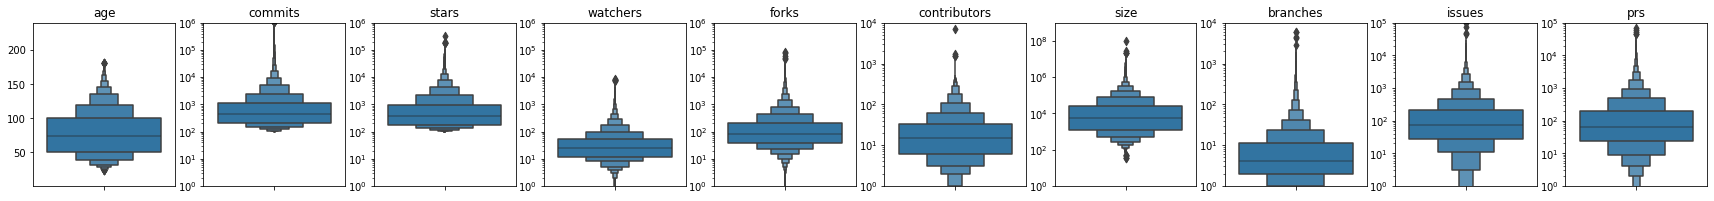

In [5]:
fields = ['age', 'commits', 'stars', 'watchers', 'forks', 'contributors', 'size', 'branches', 'issues', 'prs']
limits = [240, 10e5, 10e5, 10e5, 10e5, 10e3, 10e8, 10e3, 10e4, 10e4]
    
fig, axes = matplotlib.pyplot.subplots(ncols=len(fields), sharey=False)
fig.set_size_inches(FIG_SIZE[0] // 2 * len(fields), FIG_SIZE[1])

data = (
    df_all_repo
    .assign(age=lambda d: (d.updated.max() - d.created) / pd.to_timedelta('30 days'))
    [fields]
)

for i, field in enumerate(fields):
    ax = axes[i]
    
    seaborn.boxenplot(
        y=field,
        data=data,
        ax=ax
    )
    ax.set(
        title=field,
        ylabel=None,
        ylim=(1, limits[i]),
    )
    
    if field not in ['age']:
        ax.set(yscale='log')

In [6]:
data[fields].describe()

,age,commits,stars,watchers,forks,contributors,size,branches,issues,prs
count,69147.000000,6.914700e+04,69147.000000,69147.000000,69147.000000,68973.000000,6.914700e+04,69147.000000,69074.000000,69141.000000
mean,78.229087,2.234835e+03,1394.205345,60.040277,285.815697,33.570557,5.724676e+04,15.356140,285.878189,311.585268
std,33.334862,2.219527e+04,4545.732705,175.631309,1158.801675,80.846495,5.352129e+05,72.013201,1142.080160,1221.813497
min,23.569925,1.000000e+02,100.000000,0.000000,0.000000,0.000000,3.400000e+01,1.000000,0.000000,0.000000
25%,51.410697,2.090000e+02,178.000000,12.000000,38.000000,6.000000,1.218000e+03,2.000000,28.000000,23.000000
50%,74.745899,4.320000e+02,360.000000,24.000000,82.000000,15.000000,5.447000e+03,4.000000,76.000000,65.000000
75%,101.041258,1.130000e+03,986.000000,52.000000,206.000000,33.000000,2.586500e+04,11.000000,209.000000,203.000000
max,181.494911,1.142166e+06,321889.000000,8428.000000,85000.000000,12921.000000,1.048802e+08,6084.000000,117484.000000,69491.000000


### Language

In [7]:
(
    df_all_repo
    .groupby('language')
    .agg({'repository': 'count'})
    .sort_values('repository', ascending=False)
    .assign(proportion=lambda d: d.repository / d.repository.sum())
)

,repository,proportion
language,,
JavaScript,13542,0.195844
Python,12319,0.178157
TypeScript,6362,0.092007
Java,6105,0.088290
C++,5701,0.082448
Go,4988,0.072136
C,4314,0.062389
PHP,4005,0.057920
C#,3630,0.052497


## How many repositories have a workflow?

In [8]:
(
    df_all_repo
    [['repository', 'language']]
    .merge(
        df_repo[['repository']].assign(workflow='yes'),
        how='left',
    )
    .fillna({'workflow': 'no'})
    # .replace({'language': {'Smalltalk': 'other', 'Objective-C': 'other'}})
    .groupby(['language', 'workflow'])
    .agg({'repository': 'count'})
    .unstack()
    ['repository']
    .assign(
        nb=lambda d: d['yes'] + d['no'],
        prop=lambda d: d['nb'] / d['nb'].sum(),
        prop_yes=lambda d: d['yes'] / d['nb'],
        prop_all=lambda d: d['yes'] / d['yes'].sum(),
    )
    .sort_values('nb', ascending=False)
    .assign(cumulative=lambda d: d['prop'].cumsum())
    [['nb', 'prop', 'cumulative', 'yes', 'no', 'prop_yes', 'prop_all']]
    
    .style
    .background_gradient(vmin=0, vmax=1, subset=['prop_yes'])
    .format('{:.1%}', subset=['prop', 'cumulative', 'prop_yes', 'prop_all'])
)

workflow,nb,prop,cumulative,yes,no,prop_yes,prop_all
language,,,,,,,
JavaScript,13542,19.6%,19.6%,4730,8812,34.9%,15.9%
Python,12319,17.8%,37.4%,5654,6665,45.9%,19.0%
TypeScript,6362,9.2%,46.6%,3722,2640,58.5%,12.5%
Java,6105,8.8%,55.4%,2390,3715,39.1%,8.0%
C++,5701,8.2%,63.7%,2331,3370,40.9%,7.8%
Go,4988,7.2%,70.9%,2854,2134,57.2%,9.6%
C,4314,6.2%,77.1%,1556,2758,36.1%,5.2%
PHP,4005,5.8%,82.9%,1932,2073,48.2%,6.5%
C#,3630,5.2%,88.2%,1254,2376,34.5%,4.2%


## Do repositories with workflows exhibit different characteristics?

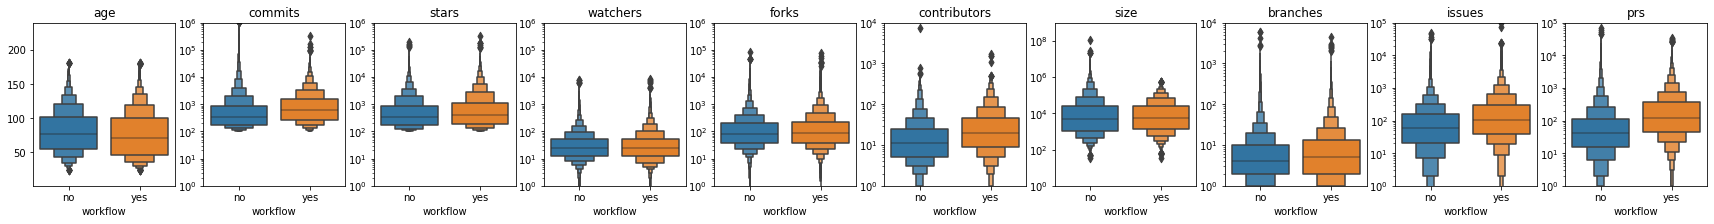

In [9]:
fields = ['age', 'commits', 'stars', 'watchers', 'forks', 'contributors', 'size', 'branches', 'issues', 'prs']
limits = [240, 10e5, 10e5, 10e5, 10e5, 10e3, 10e8, 10e3, 10e4, 10e4]
    
fig, axes = matplotlib.pyplot.subplots(ncols=len(fields), sharey=False)
fig.set_size_inches(FIG_SIZE[0] // 2 * len(fields), FIG_SIZE[1])

data = (
    df_all_repo
    .merge(
        df_repo[['repository']].assign(workflow='yes'),
        how='left',
    )
    .fillna({'workflow': 'no'})
    .assign(age=lambda d: (d.updated.max() - d.created) / pd.to_timedelta('30 days'))
    [fields + ['workflow']]
)

for i, field in enumerate(fields):
    ax = axes[i]
    
    seaborn.boxenplot(
        x='workflow',
        y=field,
        data=data,
        ax=ax
    )
    ax.set(
        title=field,
        ylabel=None,
        ylim=(1, limits[i]),
    )
    
    if field not in ['age']:
        ax.set(yscale='log')

In [10]:
data.groupby('workflow').describe().stack()

age       commits          stars      watchers  \
workflow                                                                  
no       count  39369.000000  3.936900e+04   39369.000000  39369.000000   
         mean      80.027941  2.528149e+03    1181.828545     57.607407   
         std       32.255582  2.909523e+04    3766.539040    166.950433   
         min       23.569925  1.000000e+02     100.000000      0.000000   
         25%       54.953856  1.800000e+02     171.000000     13.000000   
         50%       76.983405  3.440000e+02     334.000000     25.000000   
         75%      101.748885  8.540000e+02     876.000000     52.000000   
         max      181.494911  1.142166e+06  192400.000000   8100.000000   
yes      count  29778.000000  2.977800e+04   29778.000000  29778.000000   
         mean      75.850852  1.847048e+03    1674.985190     63.256733   
         std       34.567435  4.948703e+03    5393.416216    186.443048   
         min       23.574884  1.000000e+02     100.000000      0.000000   
         25%       46.811902  2.720000e+02     186.000000     12.000000   
         50%       71.373048  5.980000e+02     398.000000     24.000000   
         75%       99.975208  1.519750e+03    1158.750000     52.000000   
         max      181.294386  3.137960e+05  321889.000000   8428.000000   

                       forks  contributors          size      branches  \
workflow                                                                 
no       count  39369.000000  39200.000000  3.936900e+04  39369.000000   
         mean     262.421093     25.885536  7.766081e+04     13.926084   
         std     1096.574700     88.304878  7.064281e+05     74.430100   
         min        0.000000      0.000000  3.500000e+01      1.000000   
         25%       38.000000      5.000000  1.098000e+03      2.000000   
         50%       80.000000     11.000000  5.099000e+03      4.000000   
         75%      197.000000     25.000000  2.622700e+04     10.000000   
         max    85000.000000  12921.000000  1.048802e+08   6084.000000   
yes      count  29778.000000  29773.000000  2.977800e+04  29778.000000   
         mean     316.745315     43.688879  3.025768e+04     17.246793   
         std     1235.611500     68.521253  6.420161e+04     68.642965   
         min        0.000000      0.000000  3.400000e+01      1.000000   
         25%       38.000000      9.000000  1.407250e+03      2.000000   
         50%       84.000000     20.000000  5.878500e+03      5.000000   
         75%      220.000000     46.000000  2.540825e+04     13.000000   
         max    75928.000000   1756.000000  5.097170e+05   4459.000000   

                       issues           prs  
workflow                                     
no       count   39306.000000  39364.000000  
         mean      214.765379    216.495783  
         std       909.991881   1236.533305  
         min         0.000000      0.000000  
         25%        21.000000     15.000000  
         50%        59.000000     41.000000  
         75%       156.000000    113.000000  
         max     47858.000000  69491.000000  
yes      count   29768.000000  29777.000000  
         mean      379.776337    437.289754  
         std      1384.833126   1190.497913  
         min         0.000000      0.000000  
         25%        40.000000     45.000000  
         50%       105.000000    124.000000  
         75%       297.000000    363.000000  
         max    117484.000000  33853.000000

In [11]:
for field in fields:
    A = data[lambda d: d['workflow'] == 'yes'][field].dropna()
    B = data[lambda d: d['workflow'] == 'no'][field].dropna()
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:12} with vs. without: p={:.5f}; d={:.3f} ({})'.format(field, m.pvalue, d, dl))

age          with vs. without: p=0.00000; d=-0.085 (negligible)
commits      with vs. without: p=0.00000; d=0.229 (small)
stars        with vs. without: p=0.00000; d=0.078 (negligible)
watchers     with vs. without: p=0.00317; d=-0.013 (negligible)
forks        with vs. without: p=0.00003; d=0.018 (negligible)
contributors with vs. without: p=0.00000; d=0.277 (small)
size         with vs. without: p=0.00000; d=0.025 (negligible)
branches     with vs. without: p=0.00000; d=0.139 (negligible)
issues       with vs. without: p=0.00000; d=0.227 (small)
prs          with vs. without: p=0.00000; d=0.384 (medium)


## How many workflows per repository? 

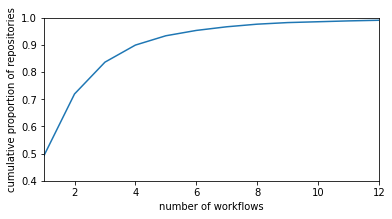

In [12]:
fig, ax = matplotlib.pyplot.subplots()

data = (
    df_workflows
    .groupby('repository', as_index=False, sort=False)
    .agg(workflows=('filename', 'count'))
    .groupby('workflows')
    .agg({'repository': 'count'})
    .assign(proportion=lambda d: d['repository'] / d['repository'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

data[['cumulative']].plot(ax=ax)
ax.set(
    xlabel='number of workflows', 
    xlim=(1, 12),
    ylabel='cumulative proportion of repositories',
    ylim=(0.4, 1)
)
ax.legend().remove()

[Text(0.5, 0, 'number of workflows'),
 Text(0, 0.5, 'proportion of repositories'),
 (0.0, 0.6)]

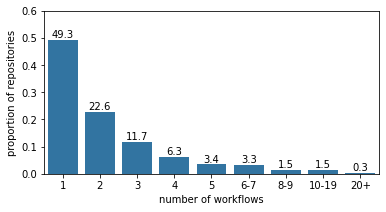

In [13]:
fig, ax = matplotlib.pyplot.subplots()

bins = [1, 2, 3, 4, 5, 6, 8, 10, 20, np.inf]
labels = [1, 2, 3, 4, 5, '6-7', '8-9', '10-19', '20+']

_ = (
    data
    .reset_index()
    .assign(bins=lambda d: pd.cut(d.workflows, bins, labels=labels, right=False))
    .groupby('bins', as_index=False, sort=False)
    .agg({'proportion': 'sum'})
)

seaborn.barplot(
    x='bins',
    y='proportion',
    data=_,
    color=PALETTE[0],
    ax=ax
)

for i, bin in enumerate(labels):
    value = _.iloc[i].proportion
    ax.annotate('{:.1f}'.format(100 * value), (i, value + 0.02), ha='center', va='center')

ax.set(
    xlabel='number of workflows',
    ylabel='proportion of repositories',
    ylim=(0, 0.6),
)

In [14]:
(
    data
    .reset_index()
    .assign(bins=lambda d: pd.cut(d.workflows, bins, labels=labels, right=False))
    .groupby('bins', sort=False)
    .agg({'repository': 'sum', 'proportion': 'sum'})
    .assign(cumulative=lambda d: d.proportion.cumsum())
    .T
)

bins,1,2,3,4,5,6-7,8-9,10-19,20+
repository,14692.000000,6731.000000,3487.000000,1870.000000,1021.000000,984.000000,460.000000,438.000000,95.00000
proportion,0.493384,0.226039,0.117100,0.062798,0.034287,0.033045,0.015448,0.014709,0.00319
cumulative,0.493384,0.719424,0.836524,0.899322,0.933609,0.966653,0.982101,0.996810,1.00000


## Most frequent workflow filenames and names? 

### Filenames

In [15]:
data = (
    df_workflows
    # Remove extension
    .assign(filename=lambda d: d.filename.str.replace(r'\.ya?ml', '', regex=True).str.lower())
    .groupby('filename', sort=False)
    .agg({'repository': 'count'})
    .sort_values('repository', ascending=False)
    .assign(proportion=lambda d: d['repository'] / d['repository'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [16]:
print(f'There are {len(data)} distinct filenames.')
print(f'There are {len(data.query("repository >= 2"))} filenames being used 2+ times')
print(f'There are {len(data.query("cumulative <= 0.5"))} distinct filenames among the first 50%')

(
    data
    # [lambda d: d['cumulative'] <= 0.5]
    [lambda d: d['proportion'] >= 0.005]
)

There are 18274 distinct filenames.
There are 4059 filenames being used 2+ times
There are 80 distinct filenames among the first 50%


,repository,proportion,cumulative
filename,,,
ci,5338,0.075955,0.075955
build,3069,0.043669,0.119625
release,2977,0.042360,0.161985
test,2779,0.039543,0.201528
codeql-analysis,2518,0.035829,0.237357
main,2370,0.033723,0.271081
tests,1401,0.019935,0.291016
lint,929,0.013219,0.304235
stale,874,0.012436,0.316671


### Names

In [17]:
data = (
    df_workflows
    .assign(name=lambda d: d.name.str.lower())
    .groupby('name', sort=False)
    .agg({'repository': 'count'})
    .sort_values('repository', ascending=False)
    .assign(proportion=lambda d: d['repository'] / d['repository'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [18]:
print(f'{len(df_workflows[lambda d: ~d.name.isnull()])} workflows have a name out of {len(df_workflows)}.')
print(f'There are {len(data)} distinct names.')
print(f'There are {len(data.query("repository >= 10"))} names being used 10+ times')
print(f'There are {len(data.query("cumulative <= 0.5"))} distinct names among the first 50%')

(
    data
    # [lambda d: d['cumulative'] <= 0.5]
    #[lambda d: d['proportion'] >= 0.005]
    .head(15)
)

69618 workflows have a name out of 70278.
There are 23056 distinct names.
There are 554 names being used 10+ times
There are 236 distinct names among the first 50%


,repository,proportion,cumulative
name,,,
ci,5674,0.081502,0.081502
build,2737,0.039315,0.120816
codeql,2407,0.034574,0.155391
release,2020,0.029015,0.184406
test,1885,0.027076,0.211483
tests,1668,0.023959,0.235442
lint,720,0.010342,0.245784
node.js ci,701,0.010069,0.255853
publish,495,0.007110,0.262964


## Which events trigger a workflow? 

### Per workflow

In [19]:
data = (
    df_workflows
    .assign(events=lambda d: d.events.str.split(', ').explode(ignore_index=True))
    .groupby('events', sort=False)
    .agg({'filename': 'count'})
    .sort_values('filename', ascending=False)
    .assign(proportion=lambda d: d['filename'] / d['filename'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [20]:
print(f'There are {len(data)} distinct events.')
print(f'There are {len(data.query("filename >= 10"))} events being used 10+ times')
print(f'There are {len(data.query("cumulative <= 0.9"))} distinct events among the first 90%')

(
    data
    .head(10)
)

There are 36 distinct events.
There are 22 events being used 10+ times
There are 3 distinct events among the first 90%


,filename,proportion,cumulative
events,,,
push,29338,0.417540,0.417540
pull_request,23926,0.340516,0.758055
workflow_dispatch,5822,0.082859,0.840914
schedule,5666,0.080639,0.921553
release,2088,0.029716,0.951269
pull_request_target,889,0.012652,0.963922
issues,699,0.009948,0.973870
repository_dispatch,520,0.007401,0.981271
issue_comment,389,0.005536,0.986807


### Per repository

In [21]:
data = (
    df_workflows
    .assign(events=lambda d: d.events.str.split(', ').explode(ignore_index=True))
    .groupby('events', sort=False)
    .agg({'repository': 'nunique'})
    .sort_values('repository', ascending=False)
    .assign(proportion=lambda d: d['repository'] / len(df_workflows.drop_duplicates('repository')))
)

In [22]:
print(f'There are {len(data)} distinct events.')
print(f'There are {len(data.query("repository >= 10"))} events being used by 10+ repositories')
print(f'There are {len(data.query("proportion >= 0.1"))} events being used by >=10% repositories')

(
    data
    .head(10)
)

There are 36 distinct events.
There are 22 events being used by 10+ repositories
There are 4 events being used by >=10% repositories


,repository,proportion
events,,
push,18890,0.634361
pull_request,16809,0.564477
schedule,4787,0.160756
workflow_dispatch,4614,0.154947
release,1855,0.062294
pull_request_target,780,0.026194
issues,625,0.020989
repository_dispatch,460,0.015448
issue_comment,353,0.011854


## How many jobs are there?

### Per workflow

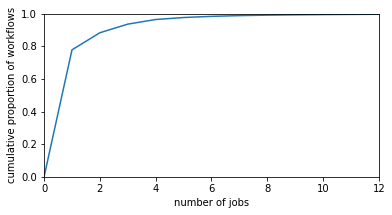

In [23]:
fig, ax = matplotlib.pyplot.subplots()

data = (
    df_workflows
    .groupby('jobs', as_index=False)
    .agg({'filename': 'count'})
    .assign(proportion=lambda d: d['filename'] / d['filename'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

data[['cumulative']].plot(ax=ax)
ax.set(
    xlabel='number of jobs', 
    xlim=(0, 12),
    ylabel='cumulative proportion of workflows',
    ylim=(0, 1)
)
ax.legend().remove()

[Text(0.5, 0, 'number of jobs'),
 Text(0, 0.5, 'proportion of workflows'),
 (0.0, 1.0)]

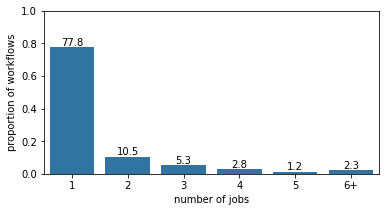

In [24]:
fig, ax = matplotlib.pyplot.subplots()

bins = [1, 2, 3, 4, 5, 6, np.inf]
labels = [1, 2, 3, 4, 5, '6+']

_ = (
    data
    .assign(bins=lambda d: pd.cut(d.jobs, bins, labels=labels, right=False))
    .groupby('bins', as_index=False, sort=False)
    .agg({'proportion': 'sum'})
)

seaborn.barplot(
    x='bins',
    y='proportion',
    data=_,
    color=PALETTE[0],
    ax=ax
)

for i, bin in enumerate(labels):
    value = _.iloc[i].proportion
    ax.annotate('{:.1f}'.format(100 * value), (i, value + 0.03), ha='center', va='center')

ax.set(
    xlabel='number of jobs',
    ylabel='proportion of workflows',
    ylim=(0, 1),
)

In [25]:
(
    data
    .assign(bins=lambda d: pd.cut(d.jobs, bins, labels=labels, right=False))
    .groupby('bins', as_index=True, sort=False)
    .agg({'proportion': 'sum'})
    .assign(cumulative=lambda d: d.proportion.cumsum())
    
    .style
    .format('{:.2%}', subset=['proportion', 'cumulative'])
)

,proportion,cumulative
bins,,
1,77.80%,77.80%
2,10.49%,88.29%
3,5.28%,93.57%
4,2.84%,96.41%
5,1.22%,97.63%
6+,2.33%,99.96%


### Per repository

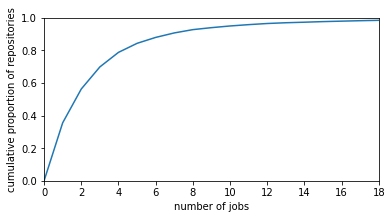

In [26]:
fig, ax = matplotlib.pyplot.subplots()

data = (
    df_workflows
    .groupby('repository', as_index=False)
    .agg({'jobs': 'sum'})
    .groupby('jobs', as_index=False)
    .agg({'repository': 'count'})
    .assign(proportion=lambda d: d['repository'] / d['repository'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

data[['cumulative']].plot(ax=ax)
ax.set(
    xlabel='number of jobs', 
    xlim=(0, 18),
    ylabel='cumulative proportion of repositories',
    ylim=(0, 1)
)
ax.legend().remove()

[Text(0.5, 0, 'number of jobs'),
 Text(0, 0.5, 'proportion of repositories'),
 (0.0, 0.5)]

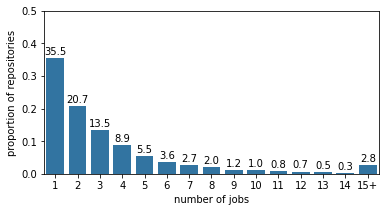

In [27]:
fig, ax = matplotlib.pyplot.subplots()

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, '15+']

_ = (
    data
    .assign(bins=lambda d: pd.cut(d.jobs, bins, labels=labels, right=False))
    .groupby('bins', as_index=False, sort=False)
    .agg({'proportion': 'sum'})
)

seaborn.barplot(
    x='bins',
    y='proportion',
    data=_,
    color=PALETTE[0],
    ax=ax
)

for i, bin in enumerate(labels):
    value = _.iloc[i].proportion
    ax.annotate('{:.1f}'.format(100 * value), (i, value + 0.02), ha='center', va='center')

ax.set(
    xlabel='number of jobs',
    ylabel='proportion of repositories',
    ylim=(0, 0.5),
)

In [28]:
(
    data
    .assign(bins=lambda d: pd.cut(d.jobs, bins, labels=labels, right=False))
    .groupby('bins', as_index=True, sort=False)
    .agg({'proportion': 'sum'})
    .assign(cumulative=lambda d: d.proportion.cumsum())
    
    .style
    .format('{:.2%}', subset=['proportion', 'cumulative'])
)

,proportion,cumulative
bins,,
1,35.52%,35.52%
2,20.73%,56.26%
3,13.55%,69.80%
4,8.91%,78.72%
5,5.54%,84.26%
6,3.63%,87.89%
7,2.75%,90.64%
8,2.02%,92.66%
9,1.21%,93.87%


## How frequently do jobs refer to other workflow?

In [29]:
(
    df_jobs
    .assign(uses=lambda d: ~d.uses.isna())
    .groupby('uses', sort=False)
    .agg({'id': 'count', 'repository': 'nunique'})
    .assign(prop_jobs=lambda d: d['id'] / d['id'].sum())
)

,id,repository,prop_jobs
uses,,,
False,107677,29692,0.992415
True,823,254,0.007585


## Where are those external jobs? 

Detect whether it came from the same repository, or from a repository of the same owner, or from an external repository.

It seems that an implicit convention is to create a `.github` repository that contains the shared workflows.

In [30]:
def origin_of_uses(row):
    if row.uses is np.nan:
        return None
    
    owner, repo = row.repository.lower().split('/')
    uses = row.uses.lower()
    if uses.startswith('./'):
        return 'local'
    if uses.startswith(row.repository):
        return 'repository'
    elif uses.startswith(owner):
        return 'owner'
    elif uses.startswith('docker://'):
        return 'docker'
    else:
        return 'other'

In [31]:
data = (
    df_jobs
    [lambda d: ~d['uses'].isnull()]
    .assign(origin=lambda d: d.apply(origin_of_uses, axis=1))
)

for origin in ['repository', 'owner', 'other']:
    _ = data[lambda d: d.origin == origin]
    _jobs = len(_)
    _workflows = len(_.drop_duplicates(['repository', 'filename']))
    _repositories = len(_.drop_duplicates(['repository']))
    
    print(f'{origin:10} {_jobs:5} jobs; {_workflows:5} workflows; {_repositories:5} repositories')
    

repository   279 jobs;   200 workflows;    64 repositories
owner        416 jobs;   344 workflows;   145 repositories
other        128 jobs;   116 workflows;    52 repositories


Here we provide a few examples:

In [32]:
(
    data
    .groupby('origin')
    .sample(5, random_state=1)
    .sort_values('origin')
    [['origin', 'repository', 'filename', 'uses']]
)

,origin,repository,filename,uses
93900,other,substack/tape,node-tens.yml,ljharb/actions/.github/workflows/node.yml@main
69613,other,openfisca/openfisca-france,validate_yaml.yml,tax-benefit/actions/.github/workflows/validate...
45346,other,ipfs/ipget,release-check.yml,protocol/.github/.github/workflows/release-che...
45349,other,ipfs/ipget,tagpush.yml,protocol/.github/.github/workflows/tagpush.yml...
38573,other,gotd/td,release.yml,go-faster/x/.github/workflows/release.yml@main
7015,owner,armbian/build,build-beta-images.yml,armbian/scripts/.github/workflows/merge-from-b...
27187,owner,edx/devstack,commitlint.yml,edx/.github/.github/workflows/commitlint.yml@m...
15238,owner,centic9/jgit-cookbook,gradle-build.yml,centic9/actions/.github/workflows/gradle-build...
7006,owner,armbian/build,build-train.yml,armbian/scripts/.github/workflows/update-repos...
42250,owner,homebridge/homebridge,release.yml,homebridge/.github/.github/workflows/nodejs-bu...


Security might be an issue when relying on external workflows (see https://docs.github.com/en/actions/security-guides/security-hardening-for-github-actions#reusing-third-party-workflows). 
GitHub suggests to specify a tag, a release or a specific commit when referring to other workflows. The two first options are not necessarily safe (e.g., one can change the tagged commit to another one). Using a specific commit is safer: assuming the corresponding code had been checked for security issues, it is very very unlikely that someone can change the content of the commit while preserving its hash. 

Let's see which options are used. It won't be easy to distinguish between branch names, tags or releases, but at least we will see how many jobs specify a specific commit.

In [33]:
(
    data
    .assign(target=lambda d: d['uses'].str.rsplit('@', n=1).str[-1])
    .groupby(['origin', 'target'])
    .agg({'id': 'count'})
    .sort_index(key=lambda s: s.str.len(), ascending=False, level='target')
    .sort_index(level='origin')
)

id
origin     target                                       
other      main                                       55
           master                                     59
           nodejs-v1                                   1
           release-v1                                  1
           v1                                         10
           v1.1.1                                      2
owner      1.1.1                                      17
           1.2.0                                       8
           1.2.1                                       1
           1.4.0                                       4
           1.4.1                                      27
           3                                           1
           d310feb31f65450fb641e8fd98645b705080a913    2
           devel                                       1
           develop                                     9
           main                                      202
           master                                    111
           site-gen                                    1
           v0.7.25                                    10
           v1                                         18
           v2                                          3
           v2022                                       1
repository 1.x                                         1
           1b5ad0078ebf1db5be0ea5253df4584f740099cb    3
           6cd0d4d96d9406635183d81cf91acc82cd78245f    2
           75ea7d4b8a3f49d7cfc809ced788ad84636369d0    2
           9aceaed29d75e9fd70742aae0574dbc9e1d4f472    3
           add_smoke_test                              2
           dev                                        16
           devel                                       1
           develop                                     8
           fix_window_arg_bug                          1
           github-workflows                            5
           main                                       57
           master                                    170
           plaidml-v1                                  2
           tcrone/fix-17                               1
           vs2019                                      5

## Most frequent job id and names?

### Job ID

In [34]:
data = (
    df_jobs
    .assign(id=lambda d: d['id'].str.lower(), jobs=1)
    .groupby('id', sort=False)
    .agg({'jobs': 'count'})
    .sort_values('jobs', ascending=False)
    .assign(proportion=lambda d: d['jobs'] / d['jobs'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [35]:
print(f'There are {len(data)} distinct job id.')
print(f'There are {len(data.query("jobs >= 10"))} job id being used by 10+ jobs')
print(f'There are {len(data.query("cumulative <= 0.9"))} distinct job id among the first 90% jobs')

(
    data
    # [lambda d: d['cumulative'] <= 0.5]
    [lambda d: d['proportion'] >= 0.005]
)

There are 23490 distinct job id.
There are 816 job id being used by 10+ jobs
There are 12640 distinct job id among the first 90% jobs


,jobs,proportion,cumulative
id,,,
build,20546,0.189364,0.189364
test,6969,0.064230,0.253594
analyze,2443,0.022516,0.276111
lint,2413,0.022240,0.298350
release,2272,0.020940,0.319290
deploy,1948,0.017954,0.337244
tests,1773,0.016341,0.353585
publish,1431,0.013189,0.366774
stale,1030,0.009493,0.376267


### Job names

In [36]:
data = (
    df_jobs
    .assign(name=lambda d: d['name'].str.lower(), jobs=1)
    .groupby('name', sort=False)
    .agg({'jobs': 'count'})
    .sort_values('jobs', ascending=False)
    .assign(proportion=lambda d: d['jobs'] / d['jobs'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [37]:
print(f'{len(df_jobs[lambda d: ~d.name.isnull()])} jobs have a name out of {len(df_jobs)}.')
print(f'There are {len(data)} distinct job names.')
print(f'There are {len(data.query("jobs >= 10"))} job names being used by 10+ jobs')
print(f'There are {len(data.query("cumulative <= 0.9"))} distinct job names among the first 90% jobs')

(
    data
    # [lambda d: d['cumulative'] <= 0.5]
    [lambda d: d['proportion'] >= 0.005]
)

44208 jobs have a name out of 108500.
There are 18994 distinct job names.
There are 415 job names being used by 10+ jobs
There are 14573 distinct job names among the first 90% jobs


,jobs,proportion,cumulative
name,,,
analyze,2352,0.053203,0.053203
build,1351,0.030560,0.083763
lint,831,0.018798,0.102561
test,664,0.015020,0.117581
release,599,0.013550,0.131130
tests,390,0.008822,0.139952
${{ matrix.name }},276,0.006243,0.146195
create release,265,0.005994,0.152190
unit tests,246,0.005565,0.157754


### Job names (and id as fallback)

In [38]:
data = (
    df_jobs
    .assign(name=lambda d: np.where(~d['name'].isnull(), d['name'], d['id']))
    .assign(name=lambda d: d['name'].str.lower(), jobs=1)
    .groupby('name', sort=False)
    .agg({'jobs': 'count'})
    .sort_values('jobs', ascending=False)
    .assign(proportion=lambda d: d['jobs'] / d['jobs'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

In [39]:
print(f'There are {len(data)} distinct job names/ids.')
print(f'There are {len(data.query("jobs >= 10"))} job names/ids being used by 10+ jobs')
print(f'There are {len(data.query("cumulative <= 0.9"))} distinct job names/ids among the first 90% jobs')

(
    data
    # [lambda d: d['cumulative'] <= 0.5]
    .head(20)
)

There are 32265 distinct job names/ids.
There are 851 job names/ids being used by 10+ jobs
There are 21415 distinct job names/ids among the first 90% jobs


,jobs,proportion,cumulative
name,,,
build,16787,0.154719,0.154719
test,4600,0.042396,0.197115
analyze,2405,0.022166,0.219281
lint,2212,0.020387,0.239668
release,1802,0.016608,0.256276
deploy,1665,0.015346,0.271622
publish,1083,0.009982,0.281604
tests,1056,0.009733,0.291336
stale,1008,0.009290,0.300627


## How many steps are there?

In [40]:
data = (
    df_jobs
    .groupby('steps')
    .agg(jobs=('id', 'count'))
    .join(
        df_jobs
        .groupby(['repository', 'filename'], as_index=False)
        .agg({'steps': 'sum'})
        .groupby('steps')
        .agg(workflows=('filename', 'count'))
        [['workflows']],
        how='outer'
    )
    .join(
        df_jobs
        .groupby(['repository'], as_index=False)
        .agg({'steps': 'sum'})
        .groupby('steps')
        .agg(repositories=('repository', 'count'))
        [['repositories']],
        how='outer'
    )
    .assign(
        jobs_p=lambda d: d['jobs'] / d['jobs'].sum(),
        workflows_p=lambda d: d['workflows'] / d['workflows'].sum(),
        repositories_p=lambda d: d['repositories'] / d['repositories'].sum(),
    )
    .assign(
        jobs_c=lambda d: d['jobs_p'].cumsum(),
        workflows_c=lambda d: d['workflows_p'].cumsum(),
        repositories_c=lambda d: d['repositories_p'].cumsum(),
    )
    [['jobs', 'jobs_p', 'jobs_c', 'workflows', 'workflows_p', 'workflows_c', 'repositories', 'repositories_p', 'repositories_c']]
)

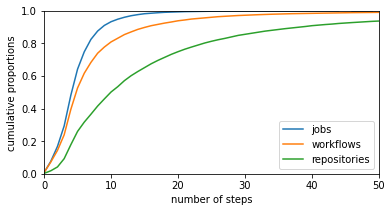

In [41]:
fig, ax = matplotlib.pyplot.subplots()

(
    data
    [['jobs_c', 'workflows_c', 'repositories_c']]
    .rename(columns={'jobs_c': 'jobs', 'workflows_c': 'workflows', 'repositories_c': 'repositories'})
    .plot(ax=ax)
)

ax.set(
    xlabel='number of steps', 
    xlim=(0, 50),
    ylabel='cumulative proportions',
    ylim=(0, 1)
)

savefig(fig, 'steps_cumulative_proportions')

In [42]:
display(
    'Per job',
    df_jobs
    [['steps']]
    .describe()
    .T
)

display(
    'Per workflow',
    df_jobs
    .groupby(['repository', 'filename'], as_index=False)
    .agg({'steps': 'sum'})
    [['steps']]
    .describe()
    .T
)

display(
    'Per repository',
    df_jobs
    .groupby(['repository'], as_index=False)
    .agg({'steps': 'sum'})
    [['steps']]
    .describe()
    .T
)

'Per job'

,count,mean,std,min,25%,50%,75%,max
steps,108500.0,5.312,3.841629,0.0,3.0,5.0,7.0,207.0


'Per workflow'

,count,mean,std,min,25%,50%,75%,max
steps,70249.0,8.204416,16.271401,0.0,4.0,5.0,9.0,1518.0


'Per repository'

,count,mean,std,min,25%,50%,75%,max
steps,29767.0,19.362112,55.52039,0.0,5.0,10.0,21.0,5529.0


## Most frequent step names

In [43]:
data = (
    df_steps
    .assign(uses=lambda d: (~d.uses.isnull()).astype(int))
    .assign(name=lambda d: d.name.str.lower())
    .groupby(['name'], as_index=False)
    .agg(steps=('pos', 'count'))
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
)

print(f'{len(data)} distinct names.')
print(f'There are {len(data.query("steps >= 100"))} names being used by 100+ steps')
print(f'There are {len(data.query("proportion >= 0.01"))} names being used by >=1% steps')

92853 distinct names.
There are 360 names being used by 100+ steps
There are 7 names being used by >=1% steps


In [44]:
(
    data
    .sort_values('steps', ascending=False)
    .head(10)
    .set_index('name')
)

,steps,proportion
name,,
install dependencies,16379,0.037212
checkout,12806,0.029095
build,8953,0.020341
run tests,6283,0.014275
test,5927,0.013466
checkout repository,5108,0.011605
checkout code,4733,0.010753
set up python ${{ matrix.python-version }},3498,0.007947
use node.js ${{ matrix.node-version }},3165,0.007191


## How frequently do steps refer to actions or external steps?

Steps can refer to external actions by using the `uses:` field. The field can either contain a reference to a public action `owner/repo@ref`, to a public action in a nested directory with `owner/repo/path@ref`, to a local action with `./path` or to a Docker image using `docker://image:tag` or `docker://host/image:tag`. The `@ref` and `:tag` are optional.
See https://docs.github.com/en/actions/using-workflows/workflow-syntax-for-github-actions#jobsjob_idstepsuses for more details.

### In absolute numbers

In [45]:
data = (
    df_steps
    .assign(kind=lambda d: d.apply(origin_of_uses, axis=1))
    .assign(uses=lambda d: (~d['uses'].isnull()).astype(int))    
)

print(f'There are {len(data[lambda d: d["uses"] == 1])} external steps.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository", "filename", "job"]))} jobs with an external step.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository", "filename"]))} workflows with an external step.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository"]))} repositories with an external step.')

There are 288475 external steps.
There are 106071 jobs with an external step.
There are 69164 workflows with an external step.
There are 29641 repositories with an external step.


### Proportionally to repositories, workflows, jobs, steps

In [46]:
print(f'There are {len(data[lambda d: d["uses"] == 1]) / len(df_steps):.2%} external steps.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository", "filename", "job"])) / len(df_jobs):.2%} jobs with an external step.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository", "filename"])) / len(df_workflows):.2%} workflows with an external step.')
print(f'There are {len(data[lambda d: d["uses"] == 1].drop_duplicates(["repository"])) / len(df_repo):.2%} repositories with an external step.')

There are 50.05% external steps.
There are 97.76% jobs with an external step.
There are 98.41% workflows with an external step.
There are 99.54% repositories with an external step.


### Proportion of external steps per job

In [47]:
(
    data
    .groupby(['repository', 'filename', 'job'], as_index=False)
    .agg(number=('uses', 'sum'), proportion=('uses', 'mean'))
    [['number', 'proportion']]
    .describe()
    .T
)

,count,mean,std,min,25%,50%,75%,max
number,107677.0,2.679077,1.713919,0.0,2.0,2.0,3.00,83.0
proportion,107677.0,0.572207,0.256065,0.0,0.4,0.5,0.75,1.0


### Proportion of external steps per repository

In [48]:
(
    data
    .groupby(['repository'], as_index=False)
    .agg(number=('uses', 'sum'), proportion=('uses', 'mean'))
    [['number', 'proportion']]
    .describe()
    .T
)

,count,mean,std,min,25%,50%,75%,max
number,29692.0,9.715580,21.741465,0.0,3.0,5.0,11.000000,1241.0
proportion,29692.0,0.544005,0.198590,0.0,0.4,0.5,0.666667,1.0


### Type of external actions

In [49]:
(
    data
    .assign(kind=lambda d: d.kind.fillna('runs'))
    .groupby('kind', sort=False)
    .agg(steps=('pos', 'count'), repo=('repository', 'nunique'))
    .sort_values('steps', ascending=False)
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
    .assign(repo_prop=lambda d: d['repo'] / len(df_repo))
)

,steps,repo,proportion,cumulative,repo_prop
kind,,,,,
runs,287877,27840,0.499481,0.499481,0.934918
other,278122,29573,0.482556,0.982037,0.993116
local,4399,605,0.007632,0.989670,0.020317
owner,4133,1286,0.007171,0.996840,0.043186
repository,958,118,0.001662,0.998503,0.003963
docker,863,525,0.001497,1.000000,0.017630


## Do actions or external steps have specific positions? 

[Text(0.5, 0, 'step position'),
 (1.0, 40.0),
 Text(0, 0.5, 'proportion of external steps')]

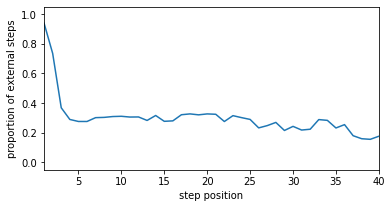

In [50]:
fig, ax = matplotlib.pyplot.subplots()

data = (
    df_steps
    .assign(uses=lambda d: (~d['uses'].isnull()).astype(int))
    .groupby(['pos'])
    .agg(steps=('uses', 'count'), nb=('uses', 'sum'), prop=('uses', 'mean'))
)

data['prop'].plot(ax=ax)

ax.set(
    xlabel='step position', 
    xlim=(1, 40),
    ylabel='proportion of external steps',
    #ylim=(0, 1),
)

In [51]:
data.head(10).T

pos,1,2,3,4,5,6,7,8,9,10
steps,107677.000000,100236.000000,90271.000000,76654.000000,56175.000000,38878.000000,27356.000000,19040.000000,13528.000000,9789.000000
nb,101092.000000,73700.000000,33251.000000,22196.000000,15505.000000,10727.000000,8254.000000,5780.000000,4183.000000,3044.000000
prop,0.938845,0.735265,0.368346,0.289561,0.276012,0.275914,0.301725,0.303571,0.309211,0.310961


### Do they have specific names?

In [52]:
data = (
    df_steps
    [lambda d: ~d.uses.isnull()]
    .assign(name=lambda d: d.name.str.lower())
    .groupby(['name'], as_index=False)
    .agg(steps=('pos', 'count'))
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
)

print(f'{len(data)} distinct names.')
print(f'There are {len(data.query("steps >= 100"))} names being used by 100+ external steps')
print(f'There are {len(data.query("proportion >= 0.01"))} names being used by >=1% external steps')

27169 distinct names.
There are 182 names being used by 100+ external steps
There are 10 names being used by >=1% external steps


In [53]:
(
    data
    .sort_values('steps', ascending=False)
    .head(15)
)

,name,steps,proportion
4860,checkout,12736,0.067783
5841,checkout repository,5104,0.027164
5087,checkout code,4724,0.025142
18451,set up python ${{ matrix.python-version }},3496,0.018606
26077,use node.js ${{ matrix.node-version }},3164,0.016839
18418,set up python,2939,0.015642
11815,initialize codeql,2896,0.015413
13943,perform codeql analysis,2871,0.015280
1359,autobuild,2221,0.011820
17998,set up docker buildx,1952,0.010389


### Is this different than for non-external steps?

In [54]:
data = (
    df_steps
    .assign(uses=lambda d: (~d.uses.isnull()).replace({True: 'external', False: 'internal'}))
    .assign(name=lambda d: d.name.str.lower())
    .groupby(['uses', 'name'], as_index=False)
    .agg(steps=('pos', 'count'))
    .pivot(index='name', columns='uses', values='steps')
    .fillna(0)
    .assign(total=lambda d: d['external'] + d['internal'])
    .sort_values('total', ascending=False)
    .assign(prop_external=lambda d: d['external'] / d['total']) 
)

In [55]:
(
    data
    .head(20)
    
    .style
    .background_gradient(subset=['prop_external'], vmin=0, vmax=1)
    .format('{:.0f}')
    .format('{:.1%}', subset='prop_external')
)

uses,external,internal,total,prop_external
name,,,,
install dependencies,391,15988,16379,2.4%
checkout,12736,70,12806,99.5%
build,316,8637,8953,3.5%
run tests,188,6095,6283,3.0%
test,125,5802,5927,2.1%
checkout repository,5104,4,5108,99.9%
checkout code,4724,9,4733,99.8%
set up python ${{ matrix.python-version }},3496,2,3498,99.9%
use node.js ${{ matrix.node-version }},3164,1,3165,100.0%


Steps that are mostly internal or external: 

In [56]:
(
    data
    # Frequently used names
    [lambda d: d['total'] >= 100]
    # Type
    .assign(type=lambda d: 
        np.where(d['prop_external'] >= 0.75, 'external', 
            np.where(d['prop_external'] <= 0.25, 'internal', 'balanced'))
    )
    .assign(names=1)
    .groupby('type')
    .agg(
        names=('names', 'count'), 
        mean=('prop_external', 'mean'), 
        median=('prop_external', 'median')
    )
    .assign(prop=lambda d: d['names'] / d['names'].sum())
)

,names,mean,median,prop
type,,,,
balanced,27,0.488884,0.501809,0.075000
external,163,0.980261,1.000000,0.452778
internal,170,0.027602,0.009016,0.472222


In [57]:
display(
    'internal', 
    data
    [lambda d: d['total'] >= 500]
    [lambda d: d['prop_external'] <= 0.25]
    .sort_values('total', ascending=False)
    .index
    .values
)

display(
    'external',
    data
    [lambda d: d['total'] >= 500]
    [lambda d: d['prop_external'] >= 0.75]
    .sort_values('total', ascending=False)
    .index
    .values
)


display(
    'balanced',
    data
    [lambda d: d['total'] >= 500]
    [lambda d: d['prop_external'].between(0.25, 0.75)]
    .sort_values('total', ascending=False)
    .index
    .values
)

'internal'

array(['install dependencies', 'build', 'run tests', 'test', 'install',
       'lint', 'configure', 'install python dependencies',
       'test with pytest', 'build with maven', 'run unit tests',
       'get yarn cache directory path', 'build with gradle', 'setup',
       'lint with flake8', 'install packages',
       'get composer cache directory', 'build and publish',
       'chown workspace', 'configure cmake', 'make', 'build package',
       'tests', 'unit tests', 'npm install'], dtype=object)

'external'

array(['checkout', 'checkout repository', 'checkout code',
       'set up python ${{ matrix.python-version }}',
       'use node.js ${{ matrix.node-version }}', 'set up python',
       'initialize codeql', 'perform codeql analysis', 'autobuild',
       'set up docker buildx', 'setup python', 'setup php', 'set up qemu',
       'set up go', 'setup node', 'check out code', 'checkout repo',
       'set up jdk 11', 'check out code into the go module directory',
       'create release', 'login to dockerhub',
       'upload coverage to codecov', 'install go', 'set up jdk 1.8',
       'build and push', 'set up jdk', 'cache dependencies',
       'setup node.js', 'upload artifacts', 'set up ruby',
       'set up python 3.7', 'setup go', 'upload artifact',
       'cache node modules', 'use node.js', 'set up python 3.8',
       'install php', 'cache pip', 'configure aws credentials',
       'setup java', 'setup ruby', 'setup .net core',
       'create pull request', 'clone repository', 'set up go 

'balanced'

array(['deploy', 'release', 'publish', 'upload coverage'], dtype=object)

## How many lines are executed by steps?

In [58]:
data = pd.concat([
    df_steps
    .groupby(['repository', 'filename', 'job', 'pos'], as_index=False)
    .agg(lines=('run', 'sum'))
    .assign(kind='step'),
    df_steps
    .groupby(['repository', 'filename', 'job'], as_index=False)
    .agg(lines=('run', 'sum'))
    .assign(kind='job'),
    df_steps
    .groupby(['repository', 'filename'], as_index=False)
    .agg(lines=('run', 'sum'))
    .assign(kind='workflow'),
    df_steps
    .groupby(['repository'], as_index=False)
    .agg(lines=('run', 'sum'))
    .assign(kind='repository')
], axis=0)[['kind', 'lines']]

[Text(0, 0.5, 'number of lines')]

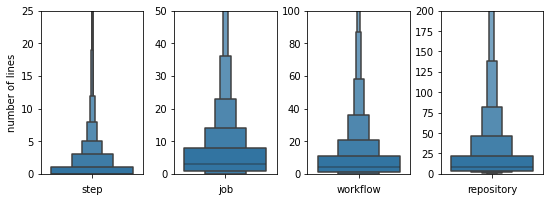

In [59]:
kinds = ['step', 'job', 'workflow', 'repository']
xlim = [25, 50, 100, 200]

fig, axes = matplotlib.pyplot.subplots(ncols=len(kinds), sharey=False, gridspec_kw={'wspace': 0.3})
fig.set_size_inches(FIG_SIZE_WIDE)

for i, kind in enumerate(kinds):
    ax = axes[i]
    seaborn.boxenplot(
        y='lines',
        data=data[lambda d: d['kind'] == kind], 
        ax=ax,
    )

    ax.set(
        xlabel=kind,
        ylabel=None,
        ylim=(0, xlim[i]),
    )

axes[0].set(ylabel='number of lines')

In [60]:
(
    data
    .groupby('kind')
    .describe()
    .loc[kinds]
)

lines                                                     
               count       mean         std  min  25%  50%   75%      max
kind                                                                     
step        576352.0   1.438683    3.961279  0.0  0.0  0.0   1.0    459.0
job         107677.0   7.700697   20.405836  0.0  1.0  3.0   8.0    961.0
workflow     69718.0  11.893456   54.488920  0.0  1.0  4.0  11.0   6288.0
repository   29692.0  27.926310  225.973583  0.0  3.0  8.0  22.0  26921.0

### Excluding empty steps (i.e., `uses:`)

[Text(0, 0.5, 'number of lines')]

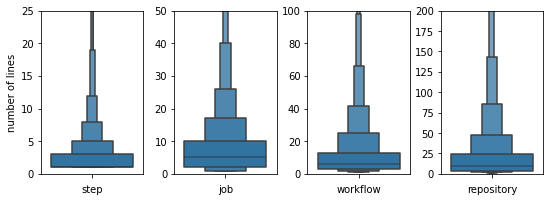

In [61]:
kinds = ['step', 'job', 'workflow', 'repository']
xlim = [25, 50, 100, 200]

fig, axes = matplotlib.pyplot.subplots(ncols=len(kinds), sharey=False, gridspec_kw={'wspace': 0.3})
fig.set_size_inches(FIG_SIZE_WIDE)

for i, kind in enumerate(kinds):
    ax = axes[i]
    seaborn.boxenplot(
        y='lines',
        data=data[lambda d: d['kind'] == kind][lambda d: d['lines'] > 0], 
        ax=ax,
    )

    ax.set(
        xlabel=kind,
        ylabel=None,
        ylim=(0, xlim[i]),
    )

axes[0].set(ylabel='number of lines')

In [62]:
(
    data
    [lambda d: d['lines'] > 0]
    .groupby('kind')
    .describe()
    .loc[kinds]
)

lines                                                     
               count       mean         std  min  25%  50%   75%      max
kind                                                                     
step        287868.0   2.880445    5.221510  1.0  1.0  1.0   3.0    459.0
job          89066.0   9.309815   22.100403  1.0  2.0  5.0  10.0    961.0
workflow     57189.0  14.499082   59.847586  1.0  3.0  6.0  13.0   6288.0
repository   27840.0  29.784052  233.250472  1.0  4.0  9.0  24.0  26921.0

### Number of lines w.r.t. position

[Text(0.5, 0, 'step position'),
 (-0.5, 29.5),
 Text(0, 0.5, 'number of lines'),
 (0.0, 25.0)]

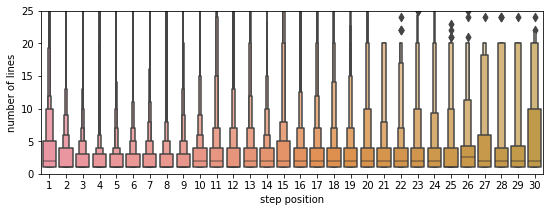

In [63]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE_WIDE)

seaborn.boxenplot(
    x='pos', 
    y='run',
    data=(
        df_steps
        [lambda d: d['run'] > 0]
    ),
    ax=ax
)

ax.set(
    xlabel='step position',
    xlim=(-0.5, 29.5),
    ylabel='number of lines',
    ylim=(0, 25),
)

In [64]:
(
    df_steps
    [lambda d: d['run'] > 0]
    .groupby('pos')
    .run
    .describe()
    .head(20)
)

,count,mean,std,min,25%,50%,75%,max
pos,,,,,,,,
1,6584.0,4.811968,15.004598,1.0,1.0,2.0,5.0,459.0
2,26536.0,3.232477,5.027870,1.0,1.0,1.0,4.0,120.0
3,57015.0,2.598369,3.812543,1.0,1.0,1.0,3.0,137.0
4,54457.0,2.448501,4.312721,1.0,1.0,1.0,3.0,384.0
5,40668.0,2.433584,3.527143,1.0,1.0,1.0,3.0,133.0
6,28151.0,2.620546,4.126855,1.0,1.0,1.0,3.0,139.0
7,19102.0,2.727201,4.196046,1.0,1.0,1.0,3.0,117.0
8,13260.0,2.902187,5.771108,1.0,1.0,1.0,3.0,430.0
9,9345.0,3.116854,5.521599,1.0,1.0,1.0,3.0,116.0


## Duplicated commands

In [65]:
data = (
    df_steps
    .assign(example=lambda d: d['repository'] + ';' + d['filename'] + ';' + d['job'] + ';' + d['pos'].astype(str) + ';' + d['name'].fillna(''))
    .groupby('run_hash', sort=False, as_index=False)
    .agg(
        steps=('run', 'count'),
        repo=('repository', 'nunique'),
        run=('run', 'first'),
        example=('example', 'first'),
    )
    .sort_values('steps', ascending=False)
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
)

print(f'{len(data)} distinct commands.')
print(f'There are {len(data.query("steps >= 100"))} commands being used by 100+ steps')
print(f'There are {len(data.query("steps >= 1000"))} commands being used by 1000+ steps')
print(f'There are {len(data.query("proportion >= 0.01"))} names being used by >=1% steps')

display(data.query('run > 1').head(20))

139501 distinct commands.
There are 134 commands being used by 100+ steps
There are 10 commands being used by 1000+ steps
There are 2 names being used by >=1% steps


,run_hash,steps,repo,run,example,proportion
25,a4ce14a77766965894b0c973662b6b729b5fbac5cbeab1...,480,469,3,0b01001001/spectree;python-publish.yml;deploy;...,0.001667
26,e63c2288d982066ea7ef9100f517c695d7f5c7aee70e24...,413,412,3,0b01001001/spectree;python-publish.yml;deploy;...,0.001435
105525,fa3364e3756addd0c3243fd530b15adabae51bda663543...,344,1,3,pytorch/pytorch;generated-linux-binary-libtorc...,0.001195
105492,a4217d95bc123b77970200b75dacff9973ca38ea8d4a9a...,315,1,11,pytorch/pytorch;generated-win-vs2019-cpu-py3.y...,0.001094
105520,99e2d6c745ead15164ef3df0a9701839c305f8abfef1ef...,312,1,2,pytorch/pytorch;generated-linux-binary-libtorc...,0.001084
105519,74e0a28a6536dc5936b9eeb8e9007b4bf7e07bb96f7fe5...,309,1,3,pytorch/pytorch;generated-linux-binary-libtorc...,0.001073
105518,ad1c7a932374c901dde5384a7cfd9888c3ead673b6bbed...,307,1,7,pytorch/pytorch;generated-linux-binary-libtorc...,0.001066
105517,dd64d2308ceb06b903062ace25fadb8263e9b86edeeff9...,307,1,7,pytorch/pytorch;generated-linux-binary-libtorc...,0.001066
105526,8989e4006077fd0c0d04e3afca580b465188505e426c2b...,306,1,6,pytorch/pytorch;generated-linux-binary-libtorc...,0.001063
1522,91798cd2a80925bcb68b48422574c907a730b6c5ef5b65...,294,95,2,act10ns/slack;test.yml;lint;2;,0.001021


## What are the most frequent actions being used?

In [66]:
data = (
    df_steps
    [lambda d: ~d.uses.isnull()]
    .assign(kind=lambda d: d.apply(origin_of_uses, axis=1))
    [lambda d: d['kind'] == 'other']
    .assign(action=lambda d: d.uses.str.rsplit('@', n=1).str[0])
)

len(data)

278122

### In steps

In [67]:
_ = (
    data
    .groupby('action', sort=False)
    .agg(steps=('uses', 'count'))
    .sort_values('steps', ascending=False)
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)
    
print(f'{len(_)} distinct actions.')
print(f'There are {len(_.query("steps >= 10"))} actions being used by 10+ steps')
print(f'There are {len(_.query("cumulative <= 0.9"))} distinct actions among the first 90% steps')

(
    _
    # [lambda d: d['cumulative'] <= 0.5]
    [lambda d: d['proportion'] >= 0.005]
    [['steps', 'proportion', 'cumulative']]
)

2964 distinct actions.
There are 724 actions being used by 10+ steps
There are 86 distinct actions among the first 90% steps


,steps,proportion,cumulative
action,,,
actions/checkout,98782,0.355175,0.355175
actions/cache,20153,0.072461,0.427636
actions/setup-node,18256,0.065640,0.493276
actions/upload-artifact,16362,0.058830,0.552107
actions/setup-python,16098,0.057881,0.609988
actions/setup-java,7255,0.026086,0.636073
actions/setup-go,6907,0.024834,0.660908
actions/download-artifact,5837,0.020987,0.681895
shivammathur/setup-php,3751,0.013487,0.695382


### In repositories

In [68]:
_ = (
    data
    .groupby('action', sort=False)
    .agg(repositories=('repository', 'nunique'))
    .sort_values('repositories', ascending=False)
    .assign(proportion=lambda d: d['repositories'] / len(data.drop_duplicates('repository')))
)
    
print(f'{len(_)} distinct actions.')
print(f'There are {len(_.query("repositories >= 10"))} actions being used by 10+ repositories')
print(f'There are {len(_.query("proportion >= 0.1"))} actions being used by >=10% repositories')

(
    _
    [lambda d: d['proportion'] >= 0.01]
    [['repositories', 'proportion']]
)

2964 distinct actions.
There are 540 actions being used by 10+ repositories
There are 6 actions being used by >=10% repositories


,repositories,proportion
action,,
actions/checkout,28931,0.978291
actions/setup-node,7771,0.262773
actions/cache,6397,0.216312
actions/setup-python,6217,0.210226
actions/upload-artifact,5535,0.187164
actions/setup-java,2960,0.100091
github/codeql-action/init,2882,0.097454
github/codeql-action/analyze,2882,0.097454
codecov/codecov-action,2783,0.094106


### Most frequent action providers

In [69]:
_ = (
    data
    .assign(provider=lambda d: d.action.str.split('/', n=1).str[0])
    .groupby('provider', sort=False)
    .agg(steps=('action', 'count'), actions=('action', 'nunique'))
    .sort_values('steps', ascending=False)
    .assign(proportion=lambda d: d['steps'] / d['steps'].sum())
    .assign(cumulative=lambda d: d['proportion'].cumsum())
)

print(f'{len(_)} providers.')
print(f'There are {len(_.query("steps >= 1000"))} providers with actions being used by 1000+ times')
print(f'There are {len(_.query("steps >= 100"))} providers with actions being used by 100+ times')

(
    _
    [['actions', 'steps', 'proportion', 'cumulative']]
    .head(20)
)

2037 providers.
There are 8 providers with actions being used by 1000+ times
There are 103 providers with actions being used by 100+ times


,actions,steps,proportion,cumulative
provider,,,,
actions,24,199549,0.717487,0.717487
docker,7,10580,0.038041,0.755528
github,9,8495,0.030544,0.786072
shivammathur,2,3815,0.013717,0.799789
codecov,1,3591,0.012912,0.812701
ruby,1,2356,0.008471,0.821172
peter-evans,17,1459,0.005246,0.826418
pypa,2,1309,0.004707,0.831124
gradle,3,991,0.003563,0.834688


## Most frequent categories

We tried to match the actions found in steps with the ones from the marketplace, in order to get their categories.

In [70]:
data = (
    df_steps
    [lambda d: ~d.uses.isnull()]
    .assign(kind=lambda d: d.apply(origin_of_uses, axis=1))
    [lambda d: d['kind'] == 'other']
    .assign(action=lambda d: d.uses.str.rsplit('@', n=1).str[0])
    .merge(
        df_actions[['action', 'repository', 'category', 'category_secondary']].rename(columns={'action': 'identifier'}),
        how='inner',
        left_on=['action'],
        right_on=['repository'],
        suffixes=(None, '_action'),
    )
    .drop(columns=['repository_action'])
    .fillna({'category': 'none', 'category_secondary': 'none'})
)

In [71]:
print(f'We found {data.action.nunique()} actions on the Marketplace, used in {len(data)} steps and {data.repository.nunique()} repositories.')

We found 752 actions on the Marketplace, used in 158441 steps and 29229 repositories.


### Action categories

In [72]:
_temp_A = (
    data
    .drop_duplicates(['action'], keep='first')
    .melt(id_vars=['action'], value_vars=['category', 'category_secondary'])
    .groupby(['variable', 'value'], as_index=False)
    .agg({'action': 'count'})
    .pivot(index='value', columns='variable', values='action')
    .fillna(0)
    .sort_values('category', ascending=False)
    .pipe(lambda df: df / df.category.sum())
)

(
    _temp_A
    .style
    .background_gradient(vmin=0, axis=None)
    .format('{:.2%}')
)

variable,category,category_secondary
value,,
Utilities,23.94%,16.62%
Continuous integration,17.29%,13.30%
Publishing,7.18%,5.45%
Deployment,6.91%,6.38%
Code quality,6.12%,2.79%
Project management,5.19%,2.79%
none,4.92%,26.99%
Dependency management,4.39%,2.79%
Code review,4.12%,2.93%


### Step categories

In [73]:
_temp_B = (
    data
    .melt(id_vars=['action'], value_vars=['category', 'category_secondary'])
    .groupby(['variable', 'value'], as_index=False)
    .agg({'action': 'count'})
    .pivot(index='value', columns='variable', values='action')
    .fillna(0)
    .sort_values('category', ascending=False)
    .pipe(lambda df: df / df.category.sum())
)

(
    _temp_B
    .style
    .background_gradient(vmin=0, axis=None)
    .format('{:.2%}')
)

variable,category,category_secondary
value,,
Utilities,88.24%,6.54%
Continuous integration,4.89%,1.57%
Container CI,2.23%,0.07%
Dependency management,1.04%,13.03%
Publishing,0.73%,0.25%
Testing,0.73%,0.43%
Project management,0.37%,0.68%
Chat,0.32%,0.05%
Code quality,0.26%,0.13%


### Per repository

In [74]:
_temp_C = (
    data
    .melt(id_vars=['repository'], value_vars=['category', 'category_secondary'])
    .groupby(['variable', 'value'], as_index=False)
    .agg({'repository': 'nunique'})
    .pivot(index='value', columns='variable', values='repository')
    .fillna(0)
    .sort_values('category', ascending=False)
    .pipe(lambda df: df / data.repository.nunique())
)

(
    _temp_C       
    .style
    .background_gradient(vmin=0, axis=None)
    .format('{:.2%}')
)

variable,category,category_secondary
value,,
Utilities,99.42%,15.43%
Continuous integration,12.90%,3.78%
Container CI,5.46%,0.16%
Publishing,2.92%,0.96%
Dependency management,2.54%,22.44%
Project management,1.57%,2.56%
Testing,1.54%,1.50%
Code quality,1.01%,0.59%
Deployment,0.65%,3.21%


All together, focusing on the most defined categories:

In [75]:
print(
    _temp_A
    .merge(_temp_B, how='outer', on='value', suffixes=('_actions', '_steps'),)
    .merge(_temp_C, how='outer', on='value', suffixes=(None, '_repo'),)
    .pipe(lambda df: df[[x for x in df.columns if 'secondary' not in x]])
    .to_string(header=False, index_names=False, float_format='{:.1%}'.format)
)

Utilities              23.9% 88.2% 99.4%
Continuous integration 17.3%  4.9% 12.9%
Publishing              7.2%  0.7%  2.9%
Deployment              6.9%  0.2%  0.6%
Code quality            6.1%  0.3%  1.0%
Project management      5.2%  0.4%  1.6%
none                    4.9%  0.2%  0.6%
Dependency management   4.4%  1.0%  2.5%
Code review             4.1%  0.1%  0.6%
Testing                 3.3%  0.7%  1.5%
Open Source management  3.3%  0.1%  0.5%
Container CI            2.3%  2.2%  5.5%
Chat                    1.9%  0.3%  0.5%
Reporting               1.7%  0.1%  0.4%
Community               1.6%  0.0%  0.1%
Security                1.6%  0.1%  0.3%
API management          0.7%  0.0%  0.1%
Mobile CI               0.7%  0.2%  0.6%
Support                 0.5%  0.0%  0.1%
AI Assisted             0.5%  0.1%  0.1%
Monitoring              0.5%  0.0%  0.0%
Code search             0.5%  0.0%  0.0%
Mobile                  0.3%  0.0%  0.0%
Localization            0.3%  0.1%  0.2%
IDEs            

Some examples

In [76]:
_ = (
    data
    .groupby('action', sort=False, as_index=False)
    .agg({'category': 'first', 'pos': 'count'})
    [lambda d: d.category.isin(_temp_A.head(16).index)]
    .groupby('category', sort=True, as_index=False)
    .apply(lambda g: 
        g
        .sort_values(['category', 'pos'], ascending=(True, False))
        .head(5)
    )
)
_
for ix, g in _.groupby('category'):
    print(ix)
    print(', '.join([f'{x.action} ({x.pos})' for x in g.itertuples()]))
    print()


Chat
8398a7/action-slack (343), rjstone/discord-webhook-notify (38), rectalogic/notify-irc (34), gottox/irc-message-action (29), lazy-actions/slatify (22)

Code quality
github/super-linter (77), preactjs/compressed-size-action (77), ammaraskar/gcc-problem-matcher (61), ammaraskar/msvc-problem-matcher (33), wearerequired/lint-action (29)

Code review
mshick/add-pr-comment (37), trilom/file-changes-action (33), marocchino/sticky-pull-request-comment (30), kentaro-m/auto-assign-action (19), khan/pull-request-comment-trigger (17)

Community
canonical/has-signed-canonical-cla (5), zofrex/mirror-branch (4), renato66/auto-label (3), nbprojekt/gource-action (2), jamessingleton/is-organization-member (1)

Container CI
docker/login-action (3213), addnab/docker-run-action (93), mirromutth/mysql-action (44), redhat-actions/buildah-build (37), akhilerm/tag-push-action (34)

Continuous integration
shivammathur/setup-php (3751), goreleaser/goreleaser-action (615), microsoft/setup-msbuild (553), ncipo

In [77]:
del _temp_A
del _temp_B
del _temp_C

## How do steps refer to external steps? 

In [78]:
def anchor_type(anchor):
    if anchor is np.nan:
        return 'none'
    elif len(anchor) == 40:
        # Heuristic to detect commit sha
        return 'sha'
    elif re.match(r'(v|V)?\d+(\.\d+(\.\d+)?)?$', anchor):
        return 'version'
    else:
        return 'branch/tag'

In [79]:
data = (
    df_steps
    [lambda d: ~d.uses.isnull()]
    .assign(kind=lambda d: d.apply(origin_of_uses, axis=1))
    
    # Exclude docker since there is no "@ref" in it (replaced by ":tag" but we don't care for now)
    [lambda d: d['kind'] != 'docker']
    .assign(action=lambda d: d.uses.str.rsplit('@', n=1).str[0])
    .assign(anchor=lambda d: d.uses.str.rsplit('@', n=1).str[1])
    .assign(anchor_type=lambda d: d.anchor.apply(anchor_type))
)

In [80]:
(
    data
    .groupby(['kind', 'anchor_type'])
    .agg(actions=('action', 'count'))
    .assign(prop_all=lambda d: d.actions / d.actions.sum())
    .assign(prop_kind=lambda d: d.actions / d.groupby('kind').sum().actions)
    .sort_index(level=1)
    .loc[(['local', 'repository', 'owner', 'other'], ['none', 'branch/tag', 'version', 'sha']), :]
    
    .style
    .background_gradient(vmin=0, vmax=1, subset=['prop_all', 'prop_kind'])
    .format('{:.1%}', subset=['prop_all', 'prop_kind'])
)

In [81]:
print(
    data
    .groupby(['kind', 'anchor_type'])
    .agg(actions=('action', 'count'))
    .assign(prop_all=lambda d: d.actions / d.actions.sum())
    .assign(prop_kind=lambda d: d.actions / d.groupby('kind').sum().actions)
    .sort_index(level=1)
    .loc[(['local', 'repository', 'owner', 'other'], ['none', 'branch/tag', 'version', 'sha']), :]
 
    .to_string(float_format='{:.1%}'.format)
)

                        actions  prop_all  prop_kind
kind       anchor_type                              
local      none            4397      1.5%     100.0%
           branch/tag         2      0.0%       0.0%
repository branch/tag       833      0.3%      87.0%
           version          123      0.0%      12.8%
           sha                2      0.0%       0.2%
owner      none               1      0.0%       0.0%
           branch/tag      1368      0.5%      33.1%
           version         2641      0.9%      63.9%
           sha              123      0.0%       3.0%
other      none               2      0.0%       0.0%
           branch/tag     14872      5.2%       5.3%
           version       258647     89.9%      93.0%
           sha             4601      1.6%       1.7%


Let's have a look at the number of components used in "version": 

In [83]:
(
    data
    [lambda d: d['anchor_type'] == 'version']
    .assign(components=lambda d: d['anchor'].str.count(r'\.') + 1)
    .groupby('components')
    .agg({'uses': 'count'})
    .sort_values('uses', ascending=False)
    .assign(prop=lambda d: d['uses'] / d['uses'].sum())
)

,uses,prop
components,,
1,234946,0.898761
3,24083,0.092127
2,2382,0.009112


Let's look at the version numbers being used. 

In [97]:
(
    data
    [lambda d: d['anchor_type'] == 'version']
    # Extract components
    .pipe(lambda df: 
        df
        .join(
            df
            .anchor
            .str.extract(r'(?:v|V)?(?P<major>\d+)(?:\.(?P<minor>\d+)(?:\.(?P<patch>\d+))?)?$')
        )
    )
    # Highest major for each action
    .pipe(lambda df: 
        df
        .merge(
            df
            .groupby('action', sort=False)
            .agg(highest_major=('major', 'max')),
            how='left',
            left_on='action',
            right_index=True
        )
    )
    .assign(has_highest=lambda d: d['major'] == d['highest_major'])
    .groupby('has_highest')
    .agg({'uses': 'count'})
    .assign(prop=lambda d: d['uses'] / d['uses'].sum())
)



,uses,prop
has_highest,,
False,42785,0.163669
True,218626,0.836331
